In [1]:
import os
import fitz
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('display.max_colwidth', None)

In [2]:
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

In [3]:
def read_resumes(base_dir, categories):
    texts = []
    names = []
    for category in categories:
        folder = os.path.join(base_dir, category)
        for fname in os.listdir(folder):
            if fname.endswith(".pdf"):
                full_path = os.path.join(folder, fname)
                text = extract_text_from_pdf(full_path)
                texts.append(text)
                names.append(fname)
    return names, texts

def read_job_descriptions(csv_path):
    df = pd.read_csv(csv_path)
    jd_texts = df['Job Description'].astype(str).tolist()
    jd_titles = df['Job Title'].astype(str).tolist()
    return jd_titles, jd_texts

In [4]:
def match_resumes_tfidf_cosine(resume_names, resume_texts, jd_titles, jd_texts, top_k=10):
    all_docs = resume_texts + jd_texts
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(all_docs)

    resume_vecs = tfidf_matrix[:len(resume_texts)]
    jd_vecs = tfidf_matrix[len(resume_texts):]

    sim_matrix = cosine_similarity(resume_vecs, jd_vecs)

    results = {}
    for i, resume_name in enumerate(resume_names):
        top_matches = sorted(
            list(enumerate(sim_matrix[i])), key=lambda x: -x[1]
        )[:top_k]
        results[resume_name] = [(idx, score, jd_titles[idx]) for idx, score in top_matches]
    return results, vectorizer, jd_texts

In [5]:
def print_full_jd(jd_titles, jd_texts, jd_id):
    if jd_id >= len(jd_titles):
        print(f"JD ID {jd_id} out of range.")
        return
    print(f"\n=== JD ID {jd_id} ===")
    print(f"Job Title: {jd_titles[jd_id]}")
    print(f"Description:\n{jd_texts[jd_id]}")

def show_top_tokens_for_match(resume_text, jd_text, vectorizer, top_n=20):
    tfidf = vectorizer.transform([resume_text, jd_text])
    feature_names = vectorizer.get_feature_names_out()
    
    r_vec = tfidf[0].toarray()[0]
    jd_vec = tfidf[1].toarray()[0]
    common_indices = (r_vec > 0) & (jd_vec > 0)
    importance = r_vec * jd_vec  # element-wise

    scored_tokens = [(feature_names[i], importance[i]) for i in range(len(importance)) if common_indices[i]]
    top_tokens = sorted(scored_tokens, key=lambda x: -x[1])[:top_n]

    print("\nTop Overlapping Tokens by TF-IDF Score:")
    for token, score in top_tokens:
        print(f"- {token}: {score:.4f}")

In [6]:
categories = ['INFORMATION-TECHNOLOGY']
base_resume_dir = './resume_pds/data/data'
jd_csv_path = 'job_title_des.csv'

In [7]:
resume_names, resume_texts = read_resumes(base_resume_dir, categories)
jd_titles, jd_texts = read_job_descriptions(jd_csv_path)

In [8]:
results, vectorizer, all_jd_texts = match_resumes_tfidf_cosine(
    resume_names, resume_texts, jd_titles, jd_texts, top_k=1
)

In [9]:
ct = 0
for resume, matches in results.items():
    print(f"\nResume: {resume}")
    for jd_id, score, title in matches:
        print(f"  JD ID: {jd_id} | Title: {title[:40]}... | Cosine Score: {score:.3f}")

    # ct += 1
    # if ct > 10:
    #     break


Resume: 18176523.pdf
  JD ID: 580 | Title: Network Administrator... | Cosine Score: 0.259

Resume: 25857360.pdf
  JD ID: 420 | Title: Database Administrator... | Cosine Score: 0.192

Resume: 39718499.pdf
  JD ID: 2172 | Title: Database Administrator... | Cosine Score: 0.106

Resume: 40018190.pdf
  JD ID: 1888 | Title: Database Administrator... | Cosine Score: 0.200

Resume: 31243710.pdf
  JD ID: 903 | Title: Network Administrator... | Cosine Score: 0.334

Resume: 25990239.pdf
  JD ID: 1888 | Title: Database Administrator... | Cosine Score: 0.213

Resume: 52246737.pdf
  JD ID: 1071 | Title: Database Administrator... | Cosine Score: 0.250

Resume: 19201175.pdf
  JD ID: 580 | Title: Network Administrator... | Cosine Score: 0.153

Resume: 36434348.pdf
  JD ID: 1348 | Title: Database Administrator... | Cosine Score: 0.270

Resume: 25207620.pdf
  JD ID: 580 | Title: Network Administrator... | Cosine Score: 0.212

Resume: 12635195.pdf
  JD ID: 23 | Title: Database Administrator... | Cosine S

In [10]:
print_full_jd(jd_titles, jd_texts, jd_id=1027)


=== JD ID 1027 ===
Job Title: Network Administrator
Description:
Job Description : Roles and Responsibilities Providing 3rd level technical support for complex problems in an operational environment; Recommending alternative solutions, priorities, systems hardware/software, design changes and improvements; Perfor

Job Description :

Roles and Responsibilities Providing 3rd level technical support for complex problems in an operational environment; Recommending alternative solutions, priorities, systems hardware/software, design changes and improvements; Performing off-hours work to support changes. Managing problems to resolution using defined process flow. Implementing changes using defined change management protocol. Performing additional responsibilities as assigned; Configure network devices Device activation and implementation Network Performance Investigation Perform WAN and LAN troubleshooting Firewall and VPN troubleshooting Monitor network devices and circuits Provide circuit

In [11]:
target_resume = '15651486.pdf'

In [12]:
show_top_tokens_for_match(
    resume_texts[resume_names.index(target_resume)],
    jd_texts[903],
    vectorizer
)


Top Overlapping Tokens by TF-IDF Score:
- cisco: 0.0871
- windows: 0.0189
- network: 0.0180
- 2003: 0.0116
- hardware: 0.0077
- administration: 0.0070
- connectivity: 0.0069
- exchange: 0.0066
- management: 0.0066
- switches: 0.0063
- printers: 0.0055
- vpn: 0.0052
- server: 0.0051
- calls: 0.0048
- routers: 0.0043
- firewall: 0.0041
- lan: 0.0041
- setup: 0.0038
- symantec: 0.0032
- hp: 0.0028


In [13]:
import os
import fitz
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import spacy

pd.set_option('display.max_colwidth', None)
nlp = spacy.load("en_core_web_sm")

def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

def tokenize(text):
    doc = nlp(text.lower())
    tokens = set()
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num and token.is_alpha:
            tokens.add(token.lemma_)
    return tokens

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

def process_resumes(folder_path):
    resume_data = {}
    for fname in os.listdir(folder_path):
        if fname.endswith('.pdf'):
            full_path = os.path.join(folder_path, fname)
            text = extract_text_from_pdf(full_path)
            tokens = tokenize(text)
            resume_data[fname] = tokens
    return resume_data

def read_resumes_raw(base_dir, categories):
    texts = []
    names = []
    for category in categories:
        folder = os.path.join(base_dir, category)
        for fname in os.listdir(folder):
            if fname.endswith(".pdf"):
                full_path = os.path.join(folder, fname)
                text = extract_text_from_pdf(full_path)
                texts.append(text)
                names.append(fname)
    return names, texts

def process_job_descriptions(csv_path):
    df = pd.read_csv(csv_path)
    jd_data = {}
    for idx, row in df.iterrows():
        jd_text = str(row['Job Description'])
        tokens = tokenize(jd_text)
        jd_data[idx] = {
            'job_title': row.get('Job Title', ''),
            'tokens': tokens,
            'full_desc': jd_text.strip()
        }
    return jd_data

def read_job_descriptions(csv_path):
    df = pd.read_csv(csv_path)
    jd_texts = df['Job Description'].astype(str).tolist()
    jd_titles = df['Job Title'].astype(str).tolist()
    return jd_titles, jd_texts

def match_resumes_to_jobs(resume_tokens, jd_data, top_k=10):
    results = defaultdict(list)
    for resume_name, r_tokens in resume_tokens.items():
        scores = []
        for jd_id, jd_info in jd_data.items():
            score = jaccard_similarity(r_tokens, jd_info['tokens'])
            scores.append((jd_id, score, jd_info['job_title']))
        top_matches = sorted(scores, key=lambda x: -x[1])[:top_k]
        results[resume_name] = top_matches
    return results

def match_resumes_tfidf_cosine(resume_names, resume_texts, jd_titles, jd_texts, top_k=10):
    all_docs = resume_texts + jd_texts
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(all_docs)

    resume_vecs = tfidf_matrix[:len(resume_texts)]
    jd_vecs = tfidf_matrix[len(resume_texts):]

    sim_matrix = cosine_similarity(resume_vecs, jd_vecs)

    results = {}
    for i, resume_name in enumerate(resume_names):
        top_matches = sorted(
            list(enumerate(sim_matrix[i])), key=lambda x: -x[1]
        )[:top_k]
        results[resume_name] = [(idx, score, jd_titles[idx]) for idx, score in top_matches]
    return results, vectorizer, jd_texts

def compare_topk_overlap(resume_name, jaccard_results, tfidf_results):
    jaccard_ids = {jd_id for jd_id, _, _ in jaccard_results.get(resume_name, [])}
    tfidf_ids = {jd_id for jd_id, _, _ in tfidf_results.get(resume_name, [])}

    overlap = jaccard_ids.intersection(tfidf_ids)

    print(f"\nResume: {resume_name}")
    print(f"Jaccard Top-K IDs: {sorted(jaccard_ids)}")
    print(f"TF-IDF Top-K IDs: {sorted(tfidf_ids)}")
    print(f"Overlap ({len(overlap)}): {sorted(overlap)}")
    print(f"Jaccard-Only: {sorted(jaccard_ids - tfidf_ids)}")
    print(f"TF-IDF-Only: {sorted(tfidf_ids - jaccard_ids)}")

def plot_score_distribution(jaccard_results, tfidf_results):
    jaccard_scores = [score for matches in jaccard_results.values() for _, score, _ in matches]
    tfidf_scores = [score for matches in tfidf_results.values() for _, score, _ in matches]

    plt.figure(figsize=(10, 5))
    plt.hist(jaccard_scores, bins=20, alpha=0.6, label='Jaccard', color='skyblue')
    plt.hist(tfidf_scores, bins=20, alpha=0.6, label='TF-IDF', color='salmon')
    plt.title("Similarity Score Distribution: Jaccard vs TF-IDF")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Resume: 20674668.pdf
Jaccard Top-K IDs: [234, 302, 374, 431, 625, 736, 1749, 1822, 1991, 2244]
TF-IDF Top-K IDs: [302, 515, 947, 955, 1214, 1425, 1943, 2145, 2236, 2244]
Overlap (2): [302, 2244]
Jaccard-Only: [234, 374, 431, 625, 736, 1749, 1822, 1991]
TF-IDF-Only: [515, 947, 955, 1214, 1425, 1943, 2145, 2236]


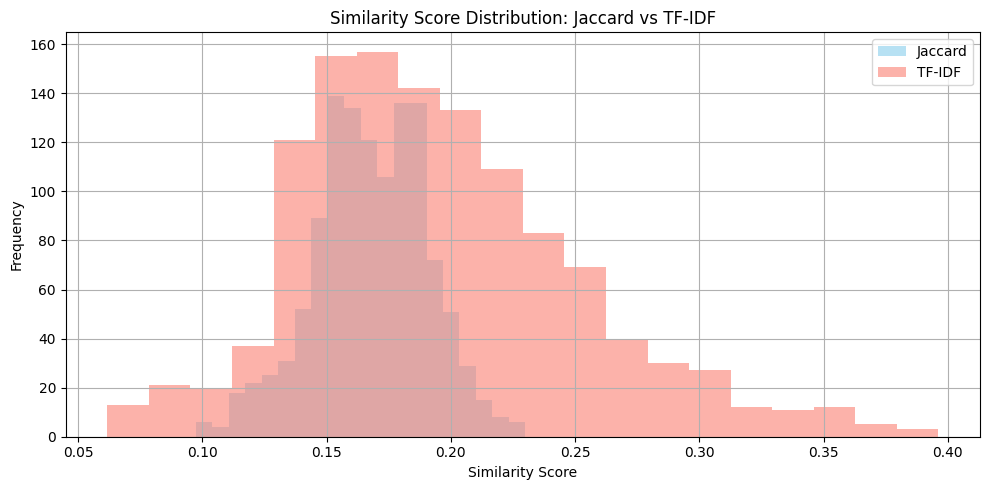

In [14]:
categories = ['INFORMATION-TECHNOLOGY']
base_resume_dir = './resume_pds/data/data'
jd_csv_path = 'job_title_des.csv'

resume_tokens = {}
for category in categories:
    folder_path = os.path.join(base_resume_dir, category)
    resume_tokens.update(process_resumes(folder_path))

resume_names, resume_texts = read_resumes_raw(base_resume_dir, categories)
jd_titles, jd_texts = read_job_descriptions(jd_csv_path)

jd_data = process_job_descriptions(jd_csv_path)
results_jaccard = match_resumes_to_jobs(resume_tokens, jd_data)
results_tfidf, vectorizer, all_jd_texts = match_resumes_tfidf_cosine(resume_names, resume_texts, jd_titles, jd_texts)

# Run comparison on a specific resume
compare_topk_overlap("20674668.pdf", results_jaccard, results_tfidf)
plot_score_distribution(results_jaccard, results_tfidf)